# ADS504 - Final Project
# Real vs Fake Job Classification
# Team 2 - Stephen Kuc, Hunter Blum, Mendelina Lopez


In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline
from google.colab import files
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline

In [120]:
job = pd.read_csv('fake_job_postings.csv')
job.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


How to attack this problem?

For text features, should we see how much each may have an affect on the real or fake job post? And then do some feature selection from there, and THEN, at that point, combine them?



## EDA 
### Structure of data

In [121]:
job.shape

(17880, 18)

17,880 observations and 18 total features.
Let's check nulls

In [122]:
job.isnull().sum()


job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2695
benefits                7210
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

In [123]:
job.dtypes

job_id                  int64
title                  object
location               object
department             object
salary_range           object
company_profile        object
description            object
requirements           object
benefits               object
telecommuting           int64
has_company_logo        int64
has_questions           int64
employment_type        object
required_experience    object
required_education     object
industry               object
function               object
fraudulent              int64
dtype: object

Many of the first features are text data, a few are binary (1,0) features,  some categorical, and :salary_range may need other transformation. 

In [124]:
job.nunique()


job_id                 17880
title                  11231
location                3105
department              1337
salary_range             874
company_profile         1709
description            14801
requirements           11968
benefits                6205
telecommuting              2
has_company_logo           2
has_questions              2
employment_type            5
required_experience        7
required_education        13
industry                 131
function                  37
fraudulent                 2
dtype: int64

employment_type, required experience, required education, function can be categorical. Industry - perhaps attacked like text data or encoded




In [125]:
# checking number of nulls in each row

NA_row = []
for i in range(len(job.index)):
  na_temp = job.iloc[i].isnull().sum()
  NA_row.append({'row': i+1, 'NAs': na_temp})

NA_row = pd.DataFrame(NA_row)
NA_row = NA_row.sort_values('NAs', ascending=False)
NA_row

,row,NAs
11077,11078,11
144,145,11
16627,16628,11
17756,17757,11
2315,2316,11
...,...,...
15825,15826,0
11435,11436,0
11441,11442,0
15789,15790,0


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


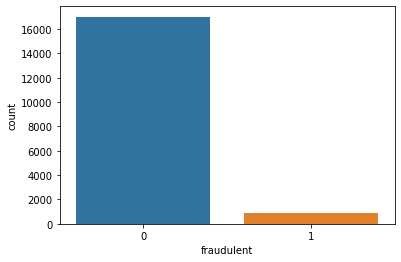

In [126]:
# creating labels / checking class distribution

labels = job['fraudulent']

sns.countplot(labels)

Do nulls have an affect on fraudulent?

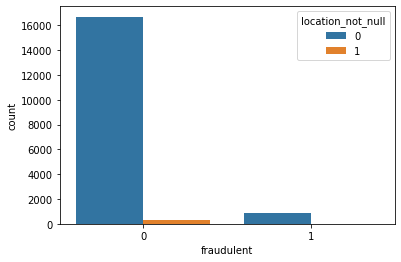

In [144]:
job['location_not_null'] = np.where(job['location'].isnull(), 1, 0)
sns.countplot(x="fraudulent", hue="location_not_null", data=job)

Maybe worth it to look at more features?

There is some class imbalance we must deal with later on. Let's get a closer look at text features

In [127]:
# let's look at each text feature
# text features are:
# 'title', 'location', 'company_profile', 'description', 'requirements', 'benefits' and (perhaps) 'industry'
# going to fill text nulls with " " 

text = job[['title','location', 'company_profile', 'description', 'requirements', 'benefits']]
text.fillna(" ", inplace = True)
text.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


,title,location,company_profile,description,requirements,benefits
0,Marketing Intern,"US, NY, New York","We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,
1,Customer Service - Cloud Video Production,"NZ, , Auckland","90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,
3,Account Executive - Washington DC,"US, DC, Washington",Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...
4,Bill Review Manager,"US, FL, Fort Worth",SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered


Vectorizing each text document

In [128]:
# vectorizing title

vectorizer = TfidfVectorizer()
spmat_title = vectorizer.fit_transform(text['title'])
feat_names = vectorizer.get_feature_names_out()
title_corpus = pd.DataFrame.sparse.from_spmatrix(spmat_title, columns=feat_names)

In [129]:
# vectorizing location

vectorizer = TfidfVectorizer()
spmat_location = vectorizer.fit_transform(text['location'])
feat_names = vectorizer.get_feature_names_out()
location_corpus = pd.DataFrame.sparse.from_spmatrix(spmat_location, columns=feat_names)

In [130]:
# vectorizing company_profile

vectorizer = TfidfVectorizer()
spmat_company = vectorizer.fit_transform(text['company_profile'])
feat_names = vectorizer.get_feature_names_out()
company_corpus = pd.DataFrame.sparse.from_spmatrix(spmat_company, columns=feat_names)

In [131]:
# vectorizing description

vectorizer = TfidfVectorizer()
spmat_description = vectorizer.fit_transform(text['description'])
feat_names = vectorizer.get_feature_names_out()
description_corpus = pd.DataFrame.sparse.from_spmatrix(spmat_description, columns=feat_names)


# vectorizing requirements

vectorizer = TfidfVectorizer()
spmat_requirements = vectorizer.fit_transform(text['requirements'])
feat_names = vectorizer.get_feature_names_out()
requirements_corpus = pd.DataFrame.sparse.from_spmatrix(spmat_requirements, columns=feat_names)

# vectorizing benefits

vectorizer = TfidfVectorizer()
spmat_benefits = vectorizer.fit_transform(text['benefits'])
feat_names = vectorizer.get_feature_names_out()
benefits_corpus = pd.DataFrame.sparse.from_spmatrix(spmat_benefits, columns=feat_names)

In [132]:
text_fts = [title_corpus, location_corpus, company_corpus, description_corpus, requirements_corpus, benefits_corpus]


In [133]:
from sklearn.linear_model import Perceptron
from sklearn.metrics import confusion_matrix, accuracy_score

text_fts = [title_corpus, location_corpus, company_corpus, description_corpus, requirements_corpus, benefits_corpus]

text_ft_accuracy = []

for i  in text_fts:
  X_train, X_test, y_train, y_test = train_test_split(i, labels, test_size = 0.80, random_state=42)
  model = Perceptron(max_iter=3).fit(X_train, y_train)
  y_pred_train = model.predict(X_train)
  y_pred_test = model.predict(X_test)
  train_acc = accuracy_score(y_train, y_pred_train)
  test_acc = accuracy_score(y_test, y_pred_test)
  text_ft_accuracy.append({'training accuracy': train_acc, 'testing accuracy': test_acc})


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_mo

In [134]:
text_ft_accuracy

[{'testing accuracy': 0.9476370246085011,
  'training accuracy': 0.9759507829977628},
 {'testing accuracy': 0.9404362416107382,
  'training accuracy': 0.9605704697986577},
 {'testing accuracy': 0.9637164429530202,
  'training accuracy': 0.9672818791946308},
 {'testing accuracy': 0.9664429530201343,
  'training accuracy': 0.9986017897091722},
 {'testing accuracy': 0.9537192393736018,
  'training accuracy': 0.9890939597315436},
 {'testing accuracy': 0.960081096196868,
  'training accuracy': 0.9759507829977628}]

In [135]:
# running this again, but with top 10, 25, and 50 features
from sklearn.feature_selection import SelectKBest, chi2

k_vals = [10, 25, 50]
text_topft_accuracy = []
for i  in text_fts:
  X_train, X_test, y_train, y_test = train_test_split(i, labels, test_size = 0.80, random_state=42)
  for k in k_vals:
    pipe = make_pipeline(SelectKBest(chi2, k = k), Perceptron(class_weight = 'balanced'))
    pipe.fit(X_train, y_train)
    y_pred_train = pipe.predict(X_train)
    y_pred_test = pipe.predict(X_test)
    cols = pipe[0].get_support(indices = True)
    new_X_features = X_train.iloc[:, cols]
    print('X_new has', k ,'best features: %s' % list(new_X_features.columns.values.tolist()))

    train_acc = accuracy_score(y_train, y_pred_train)
    test_acc = accuracy_score(y_test, y_pred_test)

    text_topft_accuracy.append({'Top k features': k, 'Training Accuracy': train_acc, 'Test Accuracy': test_acc})





X_new has 10 best features: ['100', '200', 'clerical', 'clerk', 'daily', 'earn', 'entry', 'payroll', 'urgent', 'yr']
X_new has 25 best features: ['100', '130', '200', '80', 'based', 'clerical', 'clerk', 'cruise', 'daily', 'dispatcher', 'earn', 'entry', 'from', 'immediate', 'payroll', 'positions', 'processing', 'subsea', 'typist', 'urgent', 'ust', 'work', 'workers', 'writers', 'yr']
X_new has 50 best features: ['000', '100', '130', '150', '175', '1781', '200', '23', '80', 'administrative', 'assistance', 'based', 'cash', 'clerical', 'clerk', 'clerks', 'cruise', 'daily', 'data', 'dispatcher', 'earn', 'entry', 'file', 'from', 'hand', 'home', 'immediate', 'lawn', 'managers', 'mi', 'money', 'nicu', 'northwestern', 'objc', 'pacu', 'payroll', 'perioperative', 'positions', 'processing', 'required', 'subsea', 'typist', 'urgent', 'ust', 'vessel', 'wanted', 'work', 'workers', 'writers', 'yr']
X_new has 10 best features: ['abbeville', 'arm', 'au', 'bakersfield', 'bh', 'houston', 'mateo', 'md', 'new

Order of features: [title_corpus, location_corpus, company_corpus, description_corpus, requirements_corpus, benefits_corpus]

In [136]:
pd.DataFrame(text_topft_accuracy)

,Top k features,Training Accuracy,Test Accuracy
0,10,0.049776,0.048098
1,25,0.052852,0.051174
2,50,0.059004,0.056348
3,10,0.049497,0.048238
4,25,0.914150,0.905271
5,50,0.929251,0.911284
6,10,0.049776,0.048098
7,25,0.053412,0.051314
8,50,0.053412,0.051804
9,10,0.049776,0.048098


Each text feature seemed to have very accurate results with the data, but only ones like location and benefits had accurate results with limited/most important features

### longer way below, not looped
#### first, title_corpus

X_train, X_test, y_train, y_test = train_test_split(title_corpus, labels, test_size = 0.80, random_state=42)
title_model = Perceptron(max_iter=1).fit(X_train, y_train)

title_pred = title_model.predict(X_test)

accuracy = accuracy_score(title_pred, y_test)

text_ft_accuracy = []
text_ft_accuracy.append({'Title': accuracy})

# PreProcessing of categorical data

In [137]:
# creating cat_df
# need to import onehotencoder

from sklearn.preprocessing import OneHotEncoder
# cat variables are 

cats = job[['employment_type', 'required_experience', 'required_education', 'function']]

# converting using one hot encoder

ohe = OneHotEncoder(drop = 'first', 
                    sparse = False).fit(cats) # dropping first column of each feature to not reduce redudancy
cat_data = ohe.transform(cats)
cat_df = pd.DataFrame(cat_data, columns = ohe.get_feature_names_out(['employment_type',  'required_experience', 'required_education', 'function'])) 
cat_df.head()

,employment_type_Full-time,employment_type_Other,employment_type_Part-time,employment_type_Temporary,employment_type_nan,required_experience_Director,required_experience_Entry level,required_experience_Executive,required_experience_Internship,required_experience_Mid-Senior level,...,function_Purchasing,function_Quality Assurance,function_Research,function_Sales,function_Science,function_Strategy/Planning,function_Supply Chain,function_Training,function_Writing/Editing,function_nan
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [138]:
# using these categorical variables to predict 

X_train, X_test, y_train, y_test = train_test_split(cat_df, labels, test_size = 0.80, random_state=42)

from sklearn.impute import SimpleImputer

mode_imputer = SimpleImputer(strategy = 'most_frequent') # imputing categorical features with mode
balanced_model = make_pipeline(mode_imputer, Perceptron(class_weight='balanced', random_state = 42))

balanced_model.fit(X_train, y_train)


# make predictions on training set
y_pred_b = balanced_model.predict(X_train)

# make predictions on test set
y_pred_test_b = balanced_model.predict(X_test)

# print the results 
print("Balanced Accuracy:"); print("="*len("Accuracy:"))
print(f"Balanced TRAIN: {accuracy_score(y_train, y_pred_b)}")
print(f"Balanced TEST: {accuracy_score(y_test, y_pred_test_b)}")

Balanced Accuracy:
Balanced TRAIN: 0.805648769574944
Balanced TEST: 0.7957214765100671


# Pre-processing of salary range

In [139]:
job['salary_range'].unique()

array([nan, '20000-28000', '100000-120000', '120000-150000',
       '50000-65000', '40000-50000', '60-80', '65000-70000', '75-115',
       '75000-110000', '17000-20000', '16000-28000', '95000-115000',
       '15000-18000', '50000-70000', '45000-60000', '30000-40000',
       '70000-90000', '10000-14000', '50-110', '28000-45000', '0-34300',
       '35000-40000', '9-Dec', '44000-57000', '18500-28000',
       '55000-75000', '30000-35000', '0-0', '20000-40000',
       '360000-600000', '50000-80000', '80000-100000', '52000-78000',
       '15750-15750', '40000-65000', '45000-50000', '30000-37000',
       '45000-67000', '35000-100000', '180000-216000', '45000-65000',
       '28000-32000', '0-1000', '36000-40000', '80000-110000',
       '35000-73000', '19000-19000', '60000-120000', '120000-15000000',
       '42000-55000', '90000-120000', '100000-150000', '28000-38000',
       '1600-1700', '50000-60000', '30000-70000', '32000-40000', '50-100',
       '9000-17000', '23040-28800', '105-110', '1300

Quite a mess within salary range. There are dates, numbers on different scales, and they're all strings

In [140]:
salary_range_new = []
months = [['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sept','Oct','Nov', 'Dec']]
for i in job['salary_range']:
  if '-' in i:
    low = i.split('-')[0]
    high = i.split('-')[1]
    salary_range_new.append({'min': low, 'max': high})
    

TypeError: ignored

In [ ]:
salary_range_new

### Trying (and failing) to clean salary range in one fell swoop

In [ ]:
salary_range_new = []
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sept','Oct','Nov', 'Dec']
for i in job['salary_range']:
  if '-' in i:
    low = i.split('-')[0]
    high = i.split('-')[1]
    if low or high not in months: 
      if int(low) < 100 and int(high) < 100:
        low = int(low) * 1000
        high = int(high) * 1000
        salary_range_new.append({'min': low, 'max': high})
      else:
          salary_range_new.append({'min': int(low), 'max': int(high)})
    else:
      salary_range_new.append({"old": i})
  else: 
    salary_range_new.append({"old": i})
